# Import Libraries

In [40]:
import os
import math
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Data Path

In [9]:
data_path = '../data/lfw2'

# Load Dataset

## Function to load dataset information

In [10]:
def load_dataset_info(data_path):
    dataset_info = []
    for person_name in os.listdir(data_path):
        person_dir = os.path.join(data_path, person_name)
        if os.path.isdir(person_dir):
            images = os.listdir(person_dir)
            for image in images:
                dataset_info.append({"person": person_name, "image_path": os.path.join(person_dir, image)})
    return pd.DataFrame(dataset_info)

## Use the funciton to load dataset

In [31]:
dataset_df = load_dataset_info(data_path)
dataset_df.head()

,person,image_path
0,Aaron_Eckhart,../data/lfw2\Aaron_Eckhart\Aaron_Eckhart_0001.jpg
1,Aaron_Guiel,../data/lfw2\Aaron_Guiel\Aaron_Guiel_0001.jpg
2,Aaron_Patterson,../data/lfw2\Aaron_Patterson\Aaron_Patterson_0...
3,Aaron_Peirsol,../data/lfw2\Aaron_Peirsol\Aaron_Peirsol_0001.jpg
4,Aaron_Peirsol,../data/lfw2\Aaron_Peirsol\Aaron_Peirsol_0002.jpg


# Dataset Basic Overview

## Number of Total Images

In [15]:
len(dataset_df)

13233

## Number of Total Persons

In [17]:
dataset_df['person'].nunique()

5749

# Analayze Class Distribution

In [54]:
class_counts = pd.DataFrame(dataset_df['person'].value_counts())
class_counts.head(10)

,person
George_W_Bush,530
Colin_Powell,236
Tony_Blair,144
Donald_Rumsfeld,121
Gerhard_Schroeder,109
Ariel_Sharon,77
Hugo_Chavez,71
Junichiro_Koizumi,60
Jean_Chretien,55
John_Ashcroft,53


## Average Images Per Class

In [21]:
class_counts.mean()

2.301791615933206

## Median Images Per Class

In [22]:
class_counts.median()

1.0

## Min Images Per Class

In [25]:
class_counts.min()

1

## Max Images Per Class

In [26]:
class_counts.max()

530

# Visualize Class Distribution

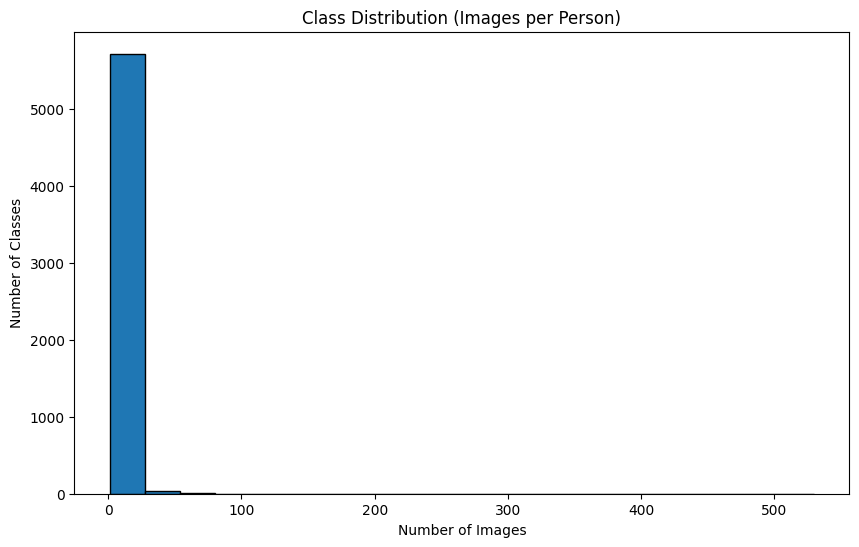

In [27]:
plt.figure(figsize=(10, 6))
plt.hist(class_counts, bins=20, edgecolor='k')
plt.title("Class Distribution (Images per Person)")
plt.xlabel("Number of Images")
plt.ylabel("Number of Classes")
plt.show()

# View Images From Dataset

## Define Function to Plot `num_samples` images

In [41]:
def plot_sample_images(dataframe, num_samples=5):
    num_samples = min(num_samples, len(dataframe))
    images_per_row = 5
    num_rows = math.ceil(num_samples / images_per_row)

    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    axs = axs.flatten() if num_rows > 1 else [axs]

    for i, (idx, row) in enumerate(dataframe.head(num_samples).iterrows()):
        image_path = row['image_path']
        image = plt.imread(image_path)
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(row['person'], fontsize=8)

    for i in range(num_samples, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()


## Ploting Images

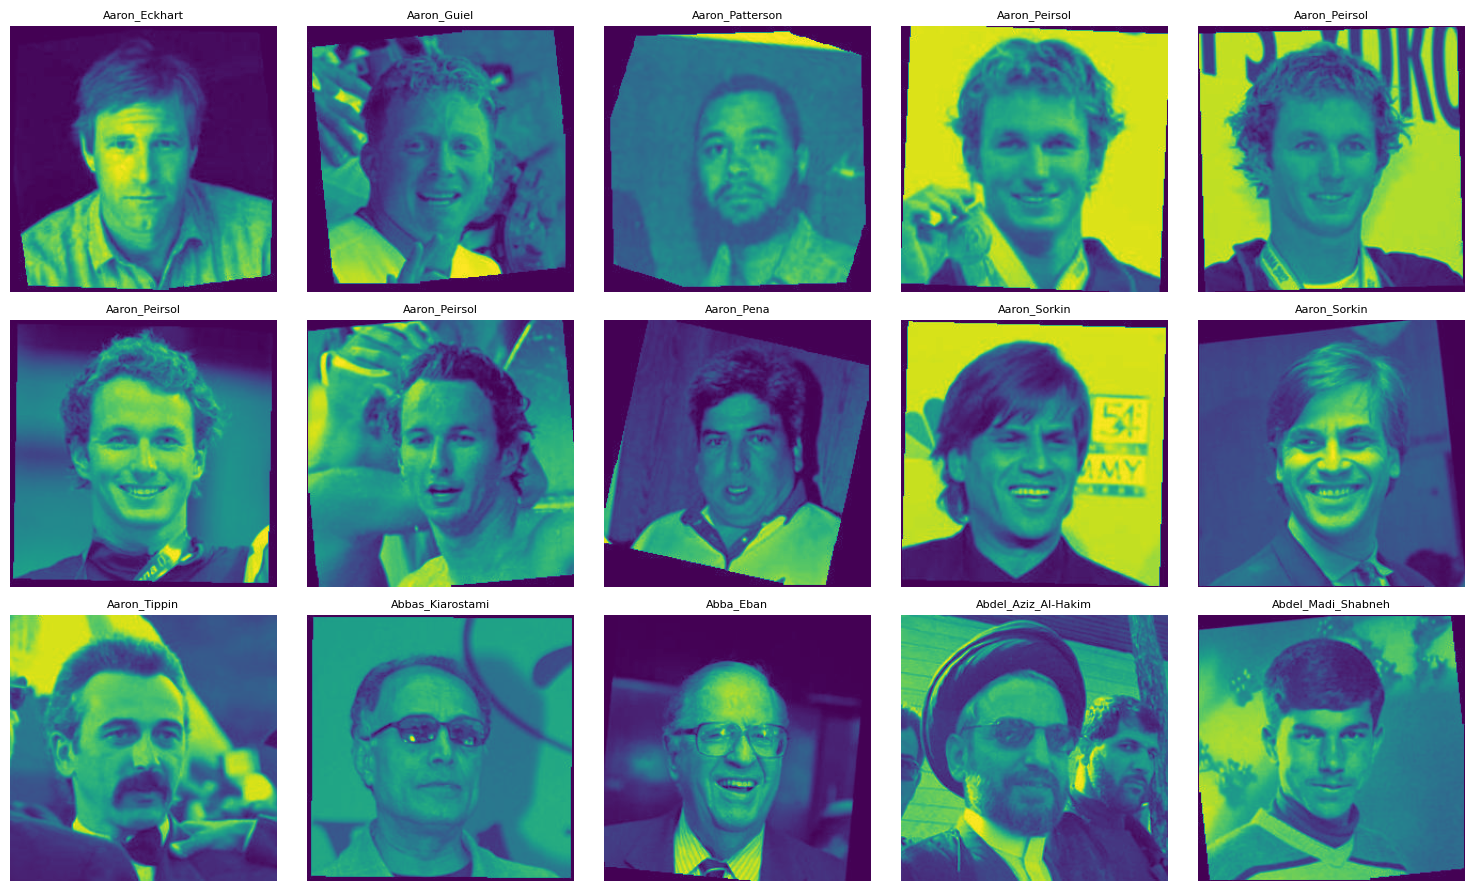

In [43]:
plot_sample_images(dataset_df, 15)

## Define Function to Plot Images of `person_name`

In [45]:
def plot_person_images(dataframe, person_name, max_images=20):
    person_df = dataframe[dataframe['person'] == person_name]

    num_images = min(max_images, len(person_df))
    images_per_row = 5
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axs = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    axs = axs.flatten() if num_rows > 1 else [axs]

    for i, (idx, row) in enumerate(person_df.head(num_images).iterrows()):
        image_path = row['image_path']
        image = plt.imread(image_path)
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(f"{row['person']}", fontsize=8)

    for i in range(num_images, len(axs)):
        axs[i].axis('off')
    
    plt.tight_layout()
    plt.show()

## Use The Function to Plot The Person With Most Images

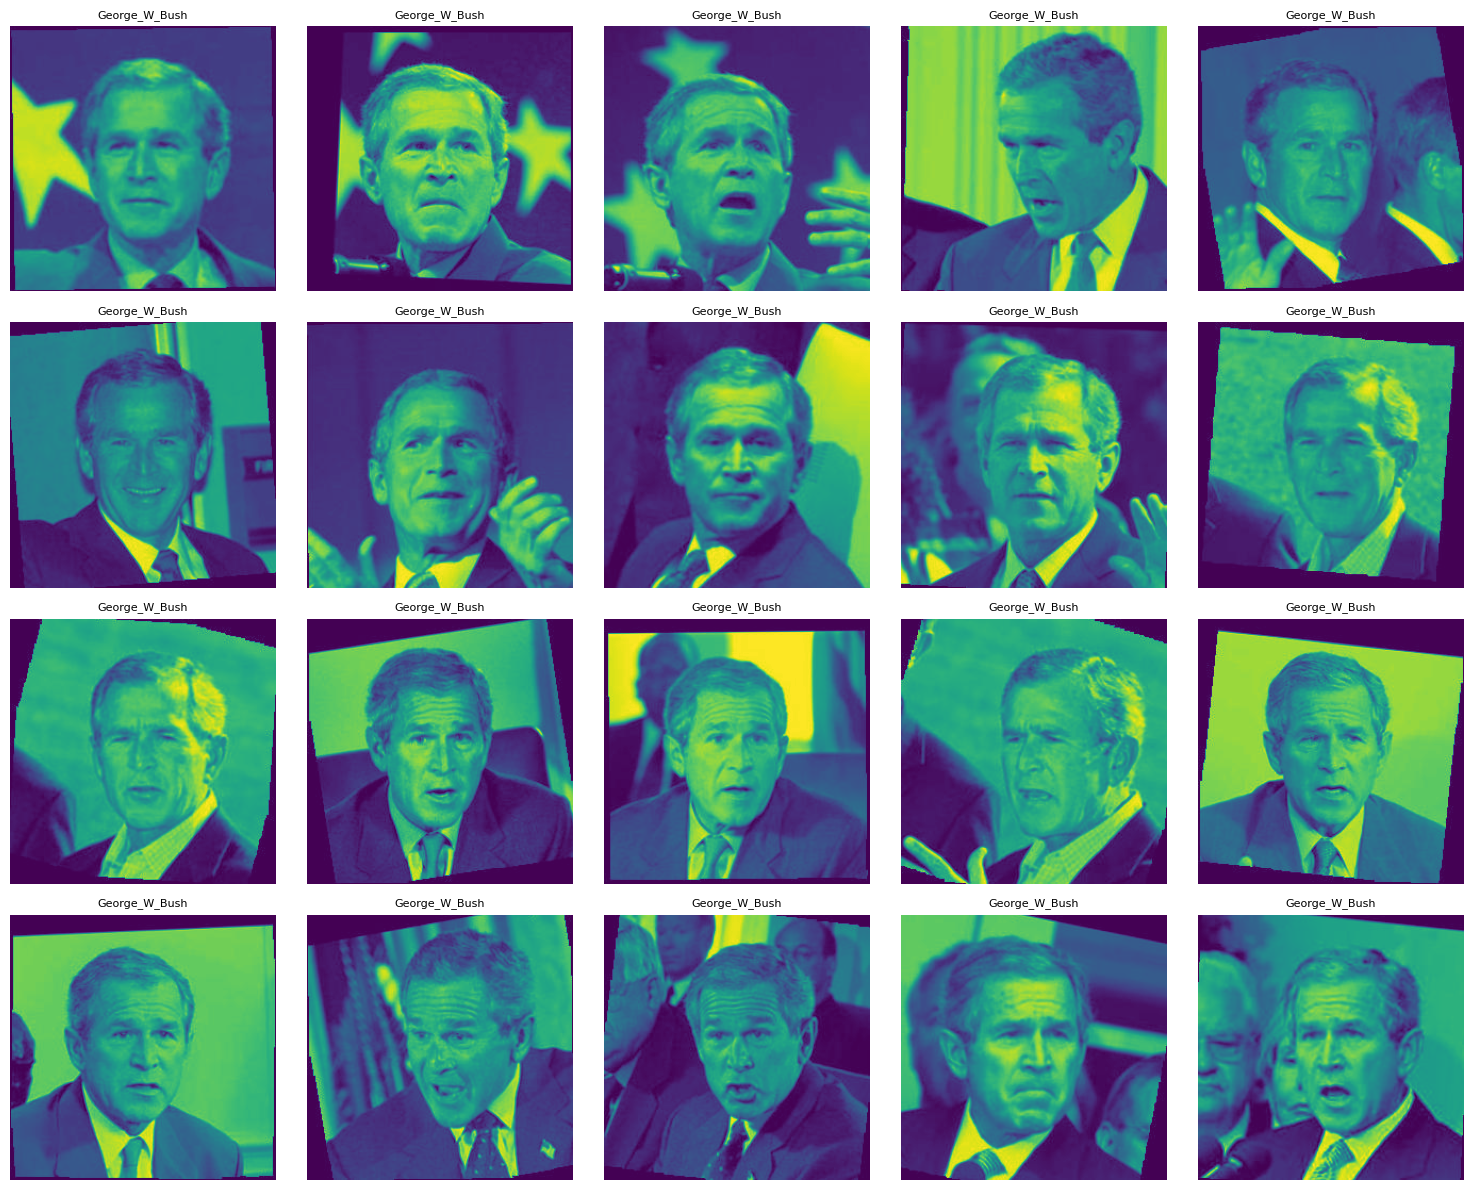

In [47]:
person_with_most_images = class_counts.idxmax()
plot_person_images(dataset_df, person_with_most_images)

# Split Dataset Into Train & Test